# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [3]:
from sklearn import linear_model, metrics, pipeline, preprocessing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

### Загрузка данных

In [5]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header=0, sep=',')

In [6]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [7]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [8]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [9]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [10]:
raw_data.shape, train_data.shape, hold_out_test_data.shape

((10886, 14), (9886, 14), (1000, 14))

In [11]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [12]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [13]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [14]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [15]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [16]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [17]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [18]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [20]:
from sklearn.linear_model import SGDRegressor

In [21]:
regressor = SGDRegressor(random_state=0, max_iter=3, loss='squared_loss', penalty='l2')

In [22]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [23]:
estimator.fit(train_data, train_labels)

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7fcaa128b730>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
         

In [24]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


120.17177172806858

### Подбор параметров

In [25]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 

In [26]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [27]:
grid_cv = GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv=4)

In [28]:
%%time
grid_cv.fit(train_data, train_labels)

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

/home/zark/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_t

/home/zark/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_t

/home/zark/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_t

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

CPU times: user 1.63 s, sys: 70.8 ms, total: 1.7 s
Wall time: 1.75 s


/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x7fcaa128b730>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                          

In [29]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.60193979729921
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}


### Оценка по отложенному тесту

In [30]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [31]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [32]:
test_labels[:20]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446, 943, 838, 531,
       432, 195, 181, 199,  49,  17,  16])

In [33]:
test_predictions[:20]

array([153.28859124, 181.89867268, 227.64068051, 262.47727954,
       278.91095558, 279.82091706, 301.6223314 , 333.35079391,
       336.28447325, 348.55425173, 346.29477487, 336.77206344,
       318.29674096, 298.65247956, 285.35831745, 246.0338046 ,
       252.72004984,  58.96734361,  66.43816405,  73.90898448])

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

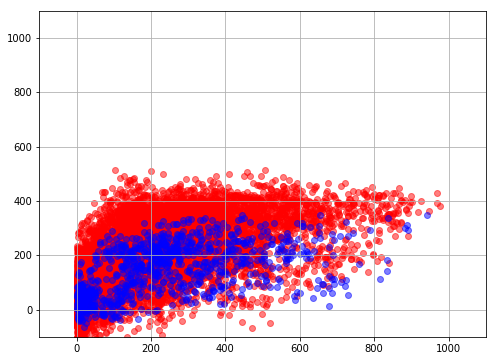

In [34]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue');

### Другая модель

In [35]:
from sklearn.ensemble import RandomForestRegressor

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [37]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)

In [38]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [39]:
estimator.fit(train_data, train_labels)

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7fcaa0e83ea0>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
         

In [40]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


79.49758619912876

In [41]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [42]:
estimator.predict(test_data)[:10]

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/zark/.local/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97:

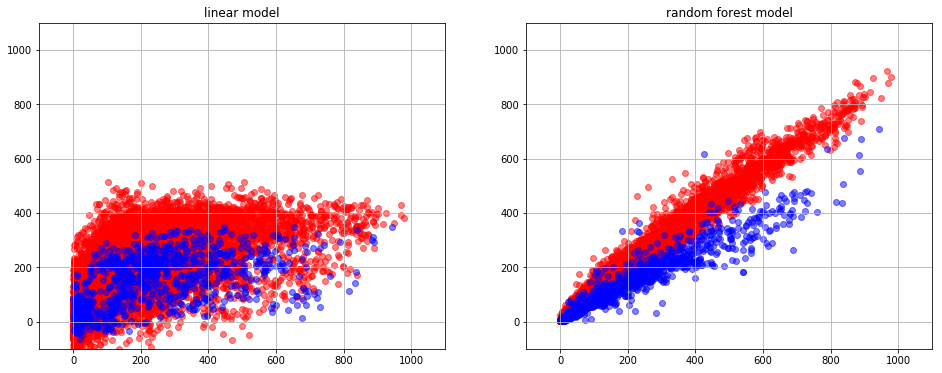

In [43]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('linear model')

plt.subplot(1,2,2)
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
plt.title('random forest model');